In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.linear_model import LinearRegression 
from utils.XYZ_to_SRGB import XYZ_TO_SRGB

from utils.utils import RootPolynomialFeatures, RobustScalableRationalFeatures
from sklearn.preprocessing import PolynomialFeatures

In [13]:
SRGB = XYZ_TO_SRGB()

In [14]:
def plot_images(images, titles):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))

    for i, (image, title) in enumerate(zip(images, titles)):
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(title)

        # Get minimum and maximum values of image
        image_min = np.min(image)
        image_max = np.max(image)

        # Add min and max values to plot
        text = f"min={image_min:.2f}, max={image_max:.2f}"
        axes[i].text(0.5, -0.1, text, transform=axes[i].transAxes,
                     fontsize=12, ha='center')

    plt.show()

<b>sRGB (standard Red Green Blue) </b> - это стандартное цветовое пространство, которое используется в большинстве компьютерных мониторов и устройств для воспроизведения цвета. Оно было разработано для обеспечения более точного и предсказуемого отображения цвета на разных устройствах и веб-страницах.

# Color space transform

Для преобразования из XYZ в sRGB можно использовать матрицу преобразования, которая связывает значения цвета в XYZ и sRGB. Вот формула для преобразования:

[sR] [ 3.2406 -1.5372 -0.4986] * [X]

[sG] = [-0.9689 1.8758 0.0415] * [Y]

[sB] [ 0.0557 -0.2040 1.0570]  * [Z]

где [X,Y,Z] - координаты цвета в XYZ, а [sR,sG,sB] - значения цвета в sRGB.


После этого необходимо выполнить обратную гамма-коррекцию, чтобы получить линейные коэффициенты RGB. Для этого к каждому значению RGB необходимо применить следующую формулу:

$$Clinear = ((Cgamma + 0.055) / 1.055) ^ 2.4, если Cgamma > 0.04045$$
$$Clinear = Cgamma / 12.92, если Cgamma <= 0.04045$$

Здесь Cgamma - это значение цвета после гамма-коррекции, а Clinear - это значение цвета в линейном представлении.

Важно отметить, что при преобразовании цветовых пространств всегда может возникнуть потеря информации или искажение цвета, поэтому необходимо производить преобразование с осторожностью и тестировать результаты на разных устройствах и в различных условиях.

In [15]:
gt = np.load("./data/2019-08-25_006_gt.npy", allow_pickle=True)

gt_xyz  = gt.item().get('image').T
gt_cmfs = gt.item().get('cmfs')

In [16]:
sRGB_img = SRGB.XYZ_to_sRGB(gt_xyz)

D:\Jupyter\HW\GitHub\CCV23.HSE\seminars\practice-03-CST\utils\XYZ_to_SRGB.py:29: UserWarning: ffs, the range should be in [0, 1] not [-0.069037 1.544540]
  warnings.warn(


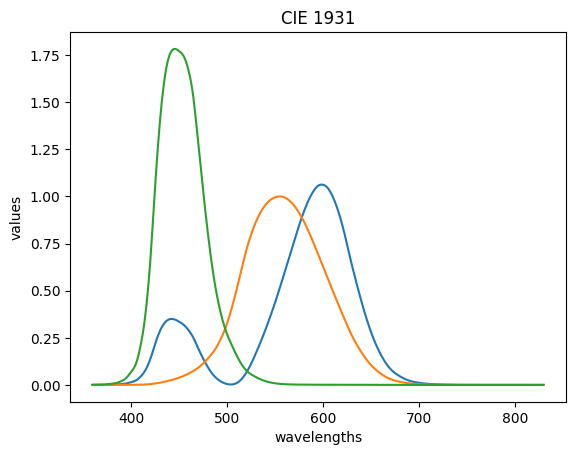

In [17]:
plt.plot(gt_cmfs["wavelengths"], gt_cmfs["values"])
plt.title("CIE 1931")
plt.xlabel("wavelengths")
plt.ylabel("values")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


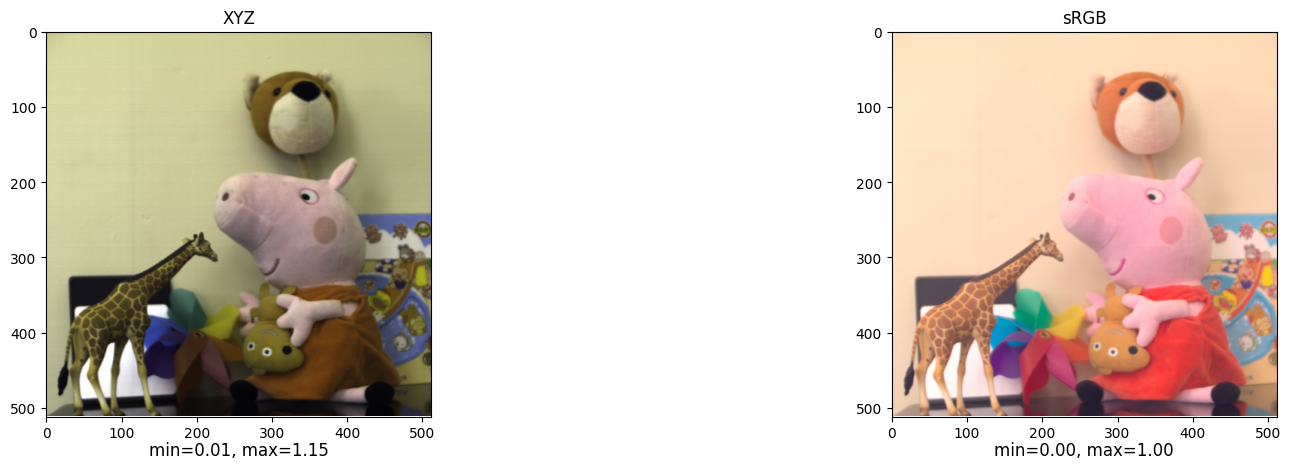

In [18]:
plot_images([gt_xyz, sRGB_img], ["XYZ", "sRGB"])

In [7]:
sample = np.load("./data/2019-08-25_006_sample.npy", allow_pickle=True)

In [8]:
sample_canon  = sample.item().get('xyz').T

In [9]:
sRGB_cannon = SRGB.XYZ_to_sRGB(sample_canon)

D:\Jupyter\HW\GitHub\CCV23.HSE\seminars\practice-03-CST\utils\XYZ_to_SRGB.py:27: UserWarning: ffs, use float32 not float64
  warnings.warn("ffs, use float32 not %s" % img.dtype)
D:\Jupyter\HW\GitHub\CCV23.HSE\seminars\practice-03-CST\utils\XYZ_to_SRGB.py:29: UserWarning: ffs, the range should be in [0, 1] not [-0.894564 1.439716]
  warnings.warn(


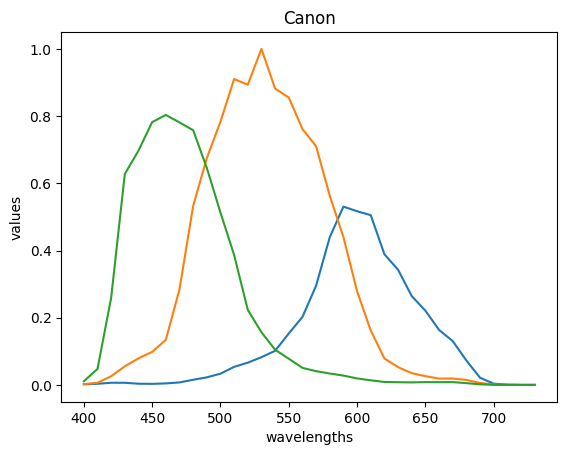

In [10]:
plt.plot(sample.item().get("cmfs")['wavelengths'], sample.item().get("cmfs")['values'])
plt.title("Canon")
plt.xlabel("wavelengths")
plt.ylabel("values")
plt.show()

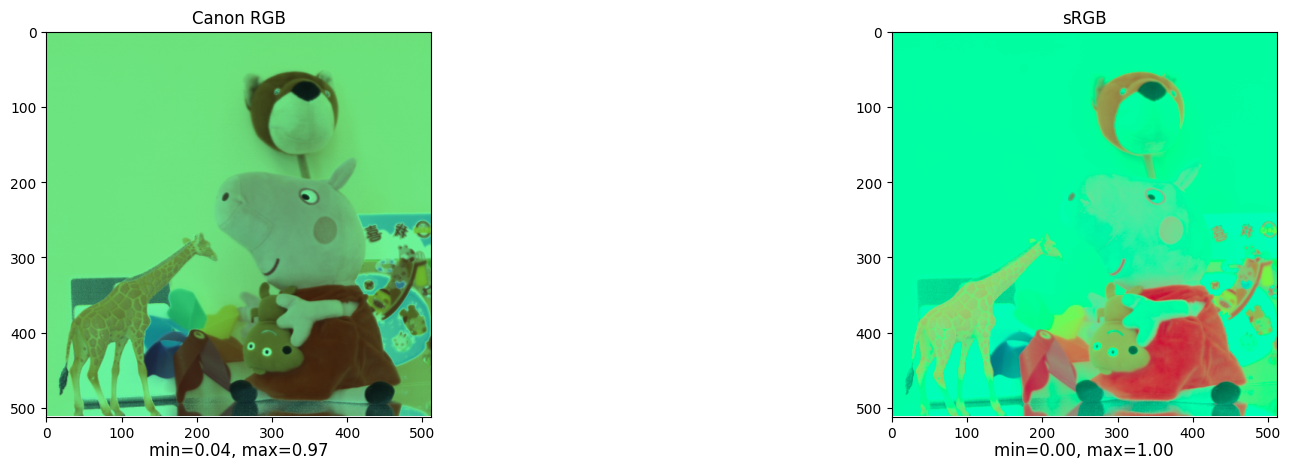

In [11]:
plot_images([sample_canon, SRGB.XYZ_to_sRGB(sample_canon)], ["Canon RGB", "sRGB"])

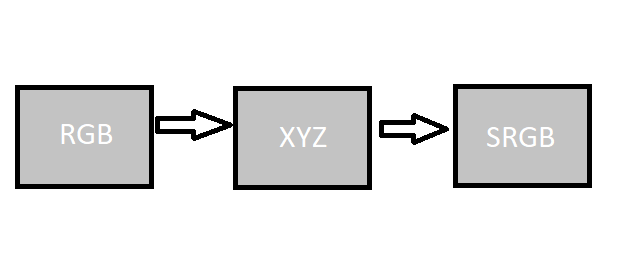

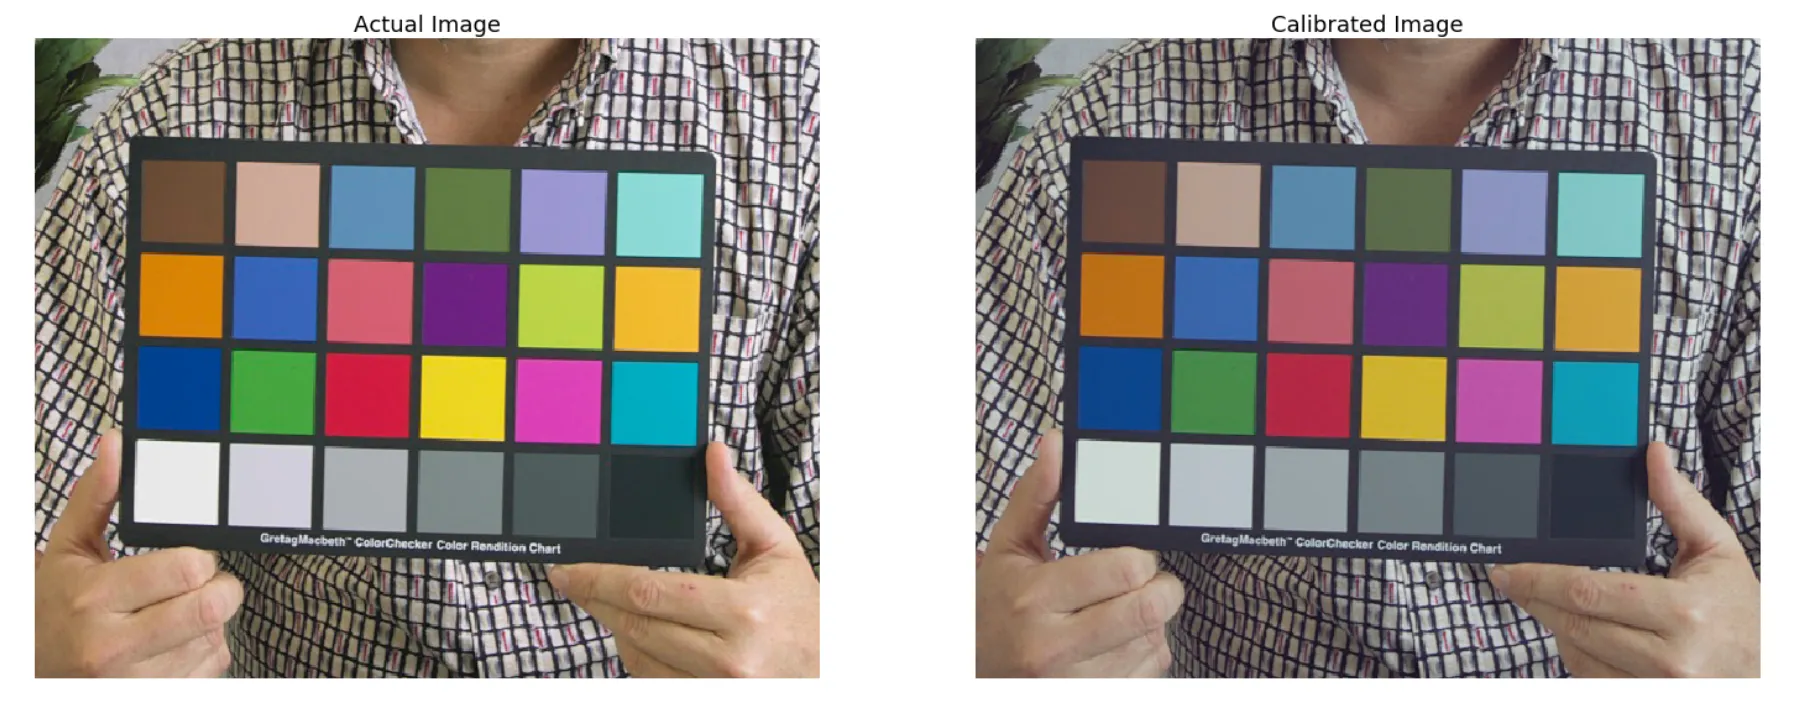

# Метирики

$$MSE = \frac{1}{mn}\sum_{i=1}^{m}\sum_{j=1}^{n}(I_{i,j} - I'_{i,j})^2$$

Здесь $I_{i,j}$ и $I'_{i,j}$ — значения пикселей соответствующих местоположений в исходном и обработанном изображениях соответственно. Сумма берется по всем $m$ строкам и $n$ столбцам изображений, и результат делится на общее количество пикселей ($mn$), чтобы получить среднюю квадратичную разницу.

Угловая метрика

Для вычисления угла между двумя векторами в трехмерном пространстве можно воспользоваться формулой для косинуса угла между векторами:

$$cos(theta) = (a * b) / (|a| * |b|),$$

где a и b - векторы, theta - угол между ними, "*" - скалярное произведение векторов, "|" - модуль вектора.

Угол между векторами можно выразить через косинус:

$$ theta = arccos(cos(theta)) $$

Далее, для перевода угла из радиан в градусы нужно умножить его на $180 / pi$.

Таким образом, формула для вычисления угла между векторами в градусах может быть записана следующим образом:

$$ theta = arccos((a * b) / (|a| * |b|)) * 180 / pi. $$

In [208]:
def mse(image1, image2):
    mse = np.mean((image1 - image2) ** 2)
    return mse

def stress(img1, img2):
    img1_1 = np.sum(np.square(img1))
    img2_2 = np.sum(np.square(img2))
    img1_2 = np.sum(img1 * img2)
    
    return (np.sqrt(1 - np.square(img1_2) / (img1_1 * img2_2)))


def calculate_angle_between_images(image1_xyz, image2_xyz):
    """
    Функция для вычисления углов между двумя XYZ изображениями.

    :param image1_xyz: массив с координатами точек на первом изображении в XYZ формате.
    :param image2_xyz: массив с координатами точек на втором изображении в XYZ формате.
    :return: массив с углами между точками на двух изображениях в градусах.
    """

    # Вычисляем количество точек на изображениях
    num_points = min(len(image1_xyz), len(image2_xyz))

    # Инициализируем массив для хранения углов между точками на двух изображениях
    angles = np.zeros(num_points)

    # Проходим по всем точкам на изображениях
    for i in range(num_points):
        # Извлекаем координаты i-й точки на двух изображениях
        x1, y1, z1 = image1_xyz[i][i]
        x2, y2, z2 = image2_xyz[i][i]

        # Вычисляем вектор между соответствующими точками на двух изображениях
        vec1 = np.array([x1, y1, z1])
        vec2 = np.array([x2, y2, z2])
        vec_diff = vec2 - vec1

        # Вычисляем длины векторов
        vec1_len = np.linalg.norm(vec1)
        vec2_len = np.linalg.norm(vec2)

        # Вычисляем косинус угла между векторами
        cos_angle = np.dot(vec1, vec2) / (vec1_len * vec2_len)

        # Вычисляем угол между векторами в градусах и сохраняем его в массиве angles
        angles[i] = np.arccos(cos_angle) * 180 / np.pi

    return angles.mean()

# Методы

### Линейная регрессия 

In [36]:
linear_regres = LinearRegression(fit_intercept=False)
linear_regres = linear_regres.fit(sample_canon.reshape(-1, 3), gt_xyz.reshape(-1, 3))

In [224]:
sample_canon.reshape(-1, 3).shape

(262144, 3)

In [225]:
linear_regres.coef_

array([[ 0.54200701,  0.7848434 , -0.42160542],
       [-0.13030294,  1.27296728, -0.7319446 ],
       [-0.28128038,  0.38261811,  0.65662703]])

In [37]:
test = linear_regres.predict(sample_canon.reshape(-1, 3)).reshape(512, 512, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


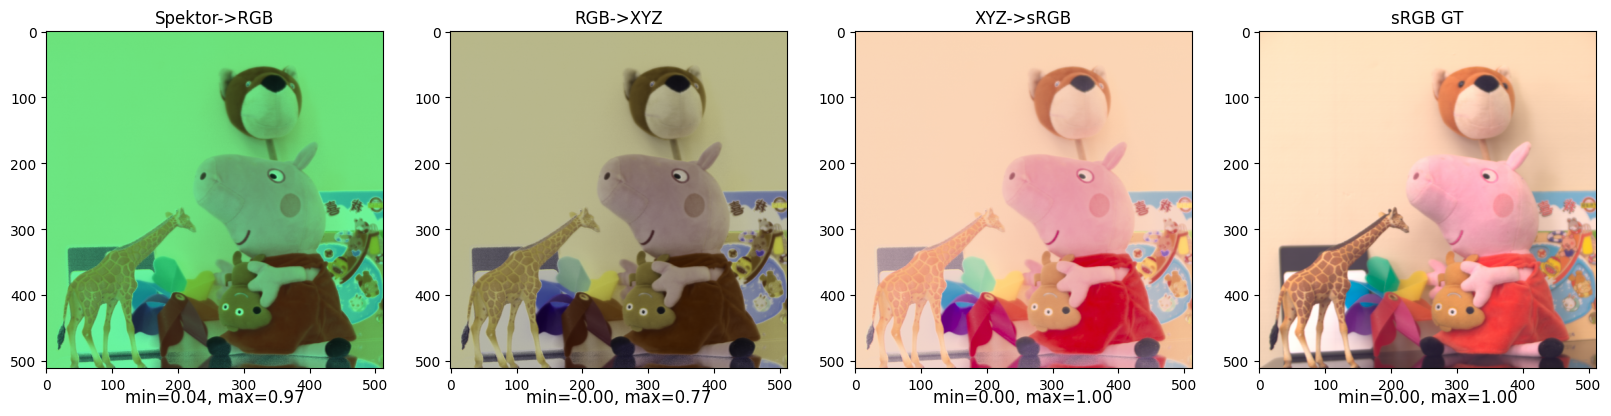

In [108]:
plot_images([sample_canon, test, SRGB.XYZ_to_sRGB(test), sRGB_img],
            ['Spektor->RGB','RGB->XYZ', 'XYZ->sRGB', 'sRGB GT'])

In [199]:
print("MSE:", mse(test, gt_xyz))

MSE: 0.019120447680600235


In [212]:
print("Angle:", calculate_angle_between_images(test, gt_xyz))

Angle: 1.2682678435760004


### Полиномиальная линейная регрессия 

Полиномиальная линейная регрессия - это метод анализа данных, который позволяет определить зависимость между двумя переменными с помощью полиномиальной функции. Он является расширением линейной регрессии, которая находит линейную зависимость между переменными.

В полиномиальной линейной регрессии мы предполагаем, что зависимость между двумя переменными может быть описана n-й степенью полинома. Функция регрессии в этом случае имеет следующий вид:

y = a0 + a1 * x + a2 * x^2 + ... + an * x^n

где y - зависимая переменная, x - независимая переменная, a0-a_n - коэффициенты, которые нужно определить.

Определение коэффициентов происходит путем минимизации суммы квадратов отклонений предсказанных значений от фактических значений. Для этого используется метод наименьших квадратов (МНК).

Полиномиальная линейная регрессия может быть полезна для моделирования нелинейных зависимостей между переменными. Однако следует помнить, что при использовании полиномов высокой степени может возникнуть проблема переобучения, когда модель подстраивается под шум в данных и не может обобщать результаты на новые данные. Поэтому важно выбирать оптимальную степень полинома, чтобы достичь хорошей точности модели и избежать переобучения.

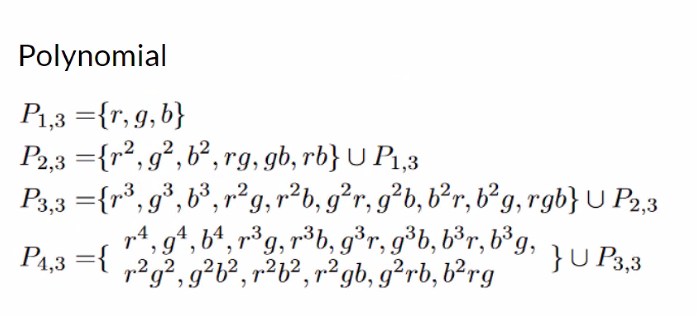

In [53]:
def pred(sample, target):
    linear_regres = LinearRegression(fit_intercept=False)
    linear_regres = linear_regres.fit(sample, target)
    return linear_regres.predict(sample).reshape(512, 512, 3)

In [47]:
y = gt_xyz.reshape(-1, 3)
X = sample_canon.reshape(-1, 3)

In [44]:
poly_transform = PolynomialFeatures(3, include_bias=False)

In [49]:
poly_X = poly_transform.fit_transform(X)

In [223]:
poly_X.shape

(262144, 19)

In [54]:
poly_img = pred(poly_X, y)

D:\Jupyter\HW\1\DataGenerator\utils\XYZ_to_SRGB.py:27: UserWarning: ffs, use float32 not float64
  warnings.warn("ffs, use float32 not %s" % img.dtype)
D:\Jupyter\HW\1\DataGenerator\utils\XYZ_to_SRGB.py:29: UserWarning: ffs, the range should be in [0, 1] not [-0.362711 1.228050]
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


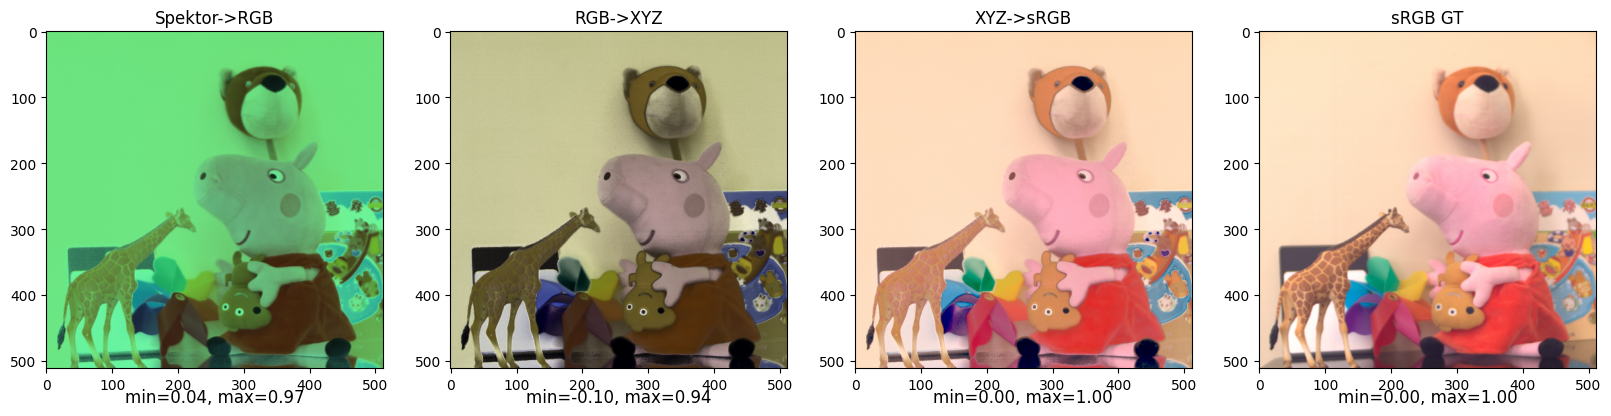

In [110]:
plot_images([sample_canon, poly_img, SRGB.XYZ_to_sRGB(poly_img), sRGB_img],
            ['Spektor->RGB','RGB->XYZ', 'XYZ->sRGB', 'sRGB GT'])

In [214]:
print("MSE:", mse(poly_img, gt_xyz))

MSE: 0.009514745295037009


In [215]:
print("Angle:", calculate_angle_between_images(poly_img, gt_xyz))

Angle: 0.5753487591013037


### Рут. Полиномиальная линейная регрессия 

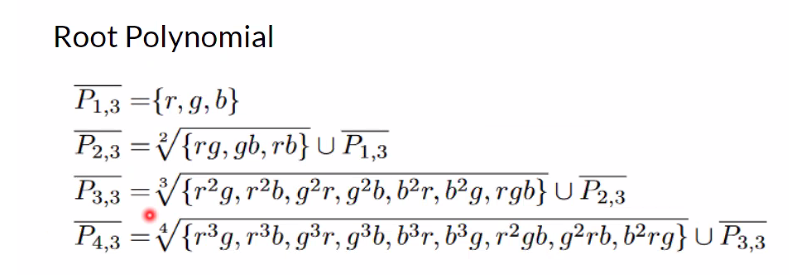

In [45]:
root_transform = RootPolynomialFeatures(4)

In [51]:
root_X = root_transform.fit_transform(X)

In [222]:
root_X.shape

(262144, 22)

In [61]:
root_img = pred(root_X, y)

D:\Jupyter\HW\1\DataGenerator\utils\XYZ_to_SRGB.py:29: UserWarning: ffs, the range should be in [0, 1] not [-0.630175 1.373943]
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


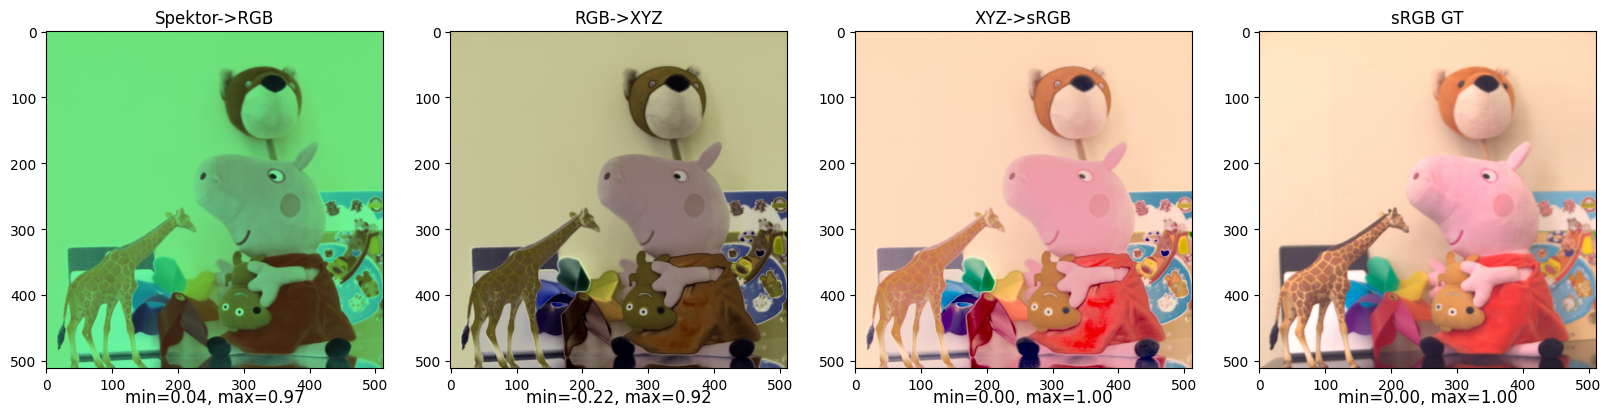

In [113]:
plot_images([sample_canon, root_img, SRGB.XYZ_to_sRGB(root_img), sRGB_img],
            ['Spektor->RGB','RGB->XYZ', 'XYZ->sRGB', 'sRGB GT'])

In [219]:
print("MSE:", mse(root_img, sRGB_img))

MSE: 0.05496814660222125


In [220]:
print("Angle:", calculate_angle_between_images(root_img, gt_xyz))

Angle: 0.7693231095202989


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


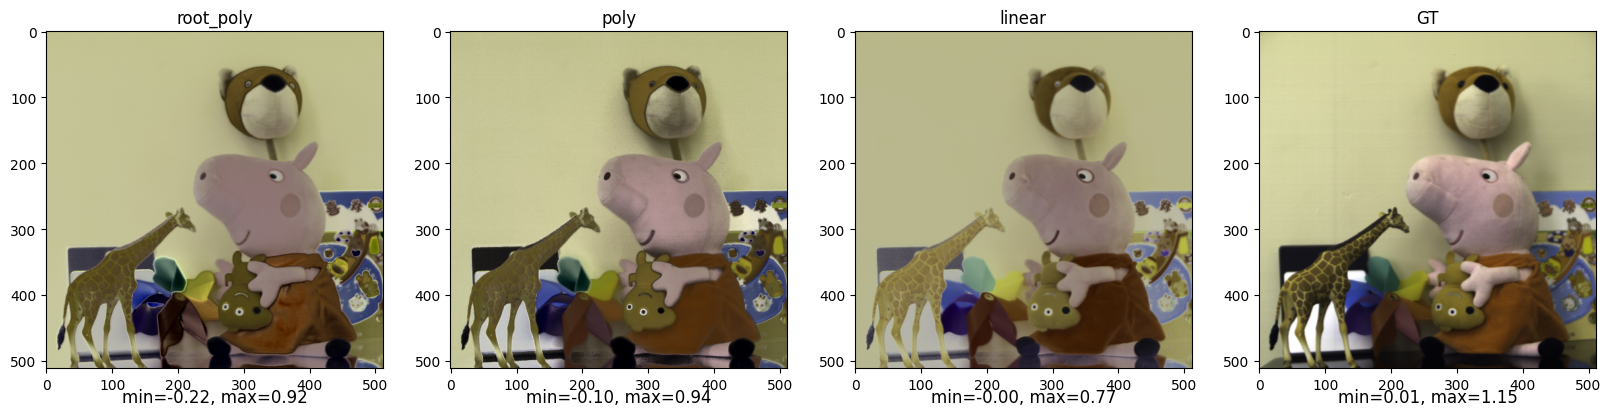

In [117]:
plot_images([root_img, poly_img, test, gt_xyz], ['root_poly', 'poly', 'linear', 'GT'])

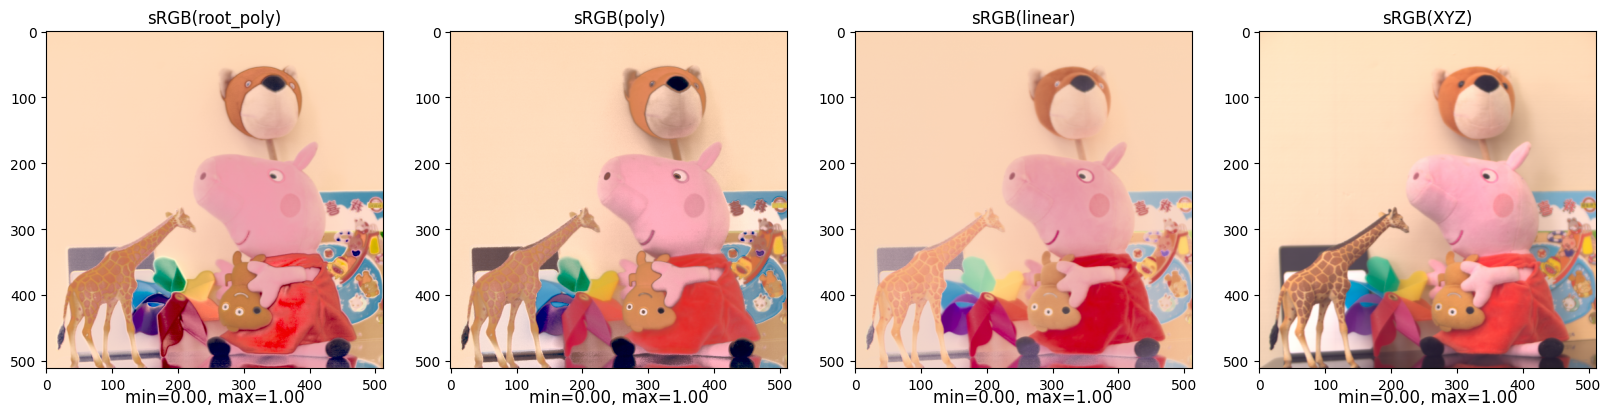

In [118]:
plot_images([SRGB.XYZ_to_sRGB(root_img),
             SRGB.XYZ_to_sRGB(poly_img),
             SRGB.XYZ_to_sRGB(test),
             SRGB.XYZ_to_sRGB(gt_xyz)],
            ['sRGB(root_poly)', 'sRGB(poly)', 'sRGB(linear)', 'sRGB(XYZ)'])

In [226]:
import torch 
import torch.nn as nn 

In [229]:
T_X = torch.FloatTensor(X)
T_y = torch.FloatTensor(y)

print(T_X.shape, T_y.shape)

torch.Size([262144, 3]) torch.Size([262144, 3])


In [230]:
class NN(nn.modules):
    def __init__(self):
        super(MyNet, self).__init__()
        self.linear1 = nn.Linear(3, 10)
        self.linear2 = nn.Linear(10, 20)
        self.linear3 = nn.Linear(20, 10)
        self.linear4 = nn.Linear(10, 3)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.relu(self.linear4(x))

TypeError: module() takes at most 2 arguments (3 given)